# Experiment Results Analysis

This notebook loads, analyzes, and visualizes the results from all forecasting experiments. It performs the following steps:

1.  **Discover Results**: Automatically finds all `test_results_*.csv` files in the `results/` directory.
2.  **Calculate Metrics**: For each result file, it calculates the overall Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
3.  **Aggregate & Compare**: Compiles all metrics into a summary table, allowing for easy comparison across different experiment configurations (`input_width`, `label_width`, `shift`).
4.  **Visualize**: Generates a plot of predictions vs. actuals for a sample slice of each experiment's test set.

## 1. Setup and Imports

In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid", palette="viridis")

## 2. Discover and Process All Experiment Results

In [2]:
RESULTS_DIR = 'results'
all_metrics = []

# Regex to parse parameters from the filename
filename_pattern = re.compile(r"test_results_iw(\d+)_lw(\d+)_sh(\d+).csv")

# Find all result CSVs
result_files = glob.glob(os.path.join(RESULTS_DIR, "test_results_*.csv"))

if not result_files:
    print(f"No result files found in '{RESULTS_DIR}'. Please run 'python eval.py' for some experiments first.")
else:
    print(f"Found {len(result_files)} experiment result(s) to analyze.\n")

    for file_path in sorted(result_files):
        filename = os.path.basename(file_path)
        match = filename_pattern.match(filename)
        
        if not match:
            print(f"Skipping file with unexpected name format: {filename}")
            continue

        # Extract parameters
        input_width, label_width, shift = map(int, match.groups())
        
        # Load data
        df = pd.read_csv(file_path)
        
        # Get prediction and actual columns
        pred_cols = [col for col in df.columns if 'prediction' in col]
        actual_cols = [col for col in df.columns if 'actual' in col]
        
        preds = df[pred_cols].values
        actuals = df[actual_cols].values

        # Calculate overall metrics
        mae = np.mean(np.abs(preds - actuals))
        rmse = np.sqrt(np.mean((preds - actuals)**2))
        mape = np.mean(np.abs((actuals - preds) / (actuals + 1e-6))) * 100
        
        # Store metrics
        metrics = {
            'input_width': input_width,
            'label_width': label_width,
            'shift': shift,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape
        }
        all_metrics.append(metrics)

# Create a summary DataFrame
summary_df = pd.DataFrame(all_metrics).sort_values(by=['input_width', 'label_width', 'shift']).reset_index(drop=True)

Found 6 experiment result(s) to analyze.



## 3. Compare Overall Metrics

The table below shows the performance of each model configuration on the test set. Lower MAE, RMSE, and MAPE values are better.

- **MAE (Mean Absolute Error)**: The average absolute difference between predicted and actual values. It's easy to interpret as it's in the original units (°C).
- **RMSE (Root Mean Squared Error)**: Similar to MAE, but penalizes larger errors more heavily.
- **MAPE (Mean Absolute Percentage Error)**: The error as a percentage of the actual value. Useful for a relative sense of error.

In [3]:
if not summary_df.empty:
    display(summary_df.style.format('{:.4f}', subset=['MAE', 'RMSE']).format('{:.2f}', subset=['MAPE (%)']))
else:
    print("Summary table is empty.")

,input_width,label_width,shift,MAE,RMSE,MAPE (%)
0,24,1,1,0.3517,0.5066,9.35
1,24,1,6,1.2274,1.6143,35.50
2,24,1,24,1.9861,2.5314,58.52
3,24,6,1,0.1145,0.2307,3.25
4,72,1,1,0.3619,0.5181,9.04
5,72,6,6,0.8451,1.2037,24.64


## 4. Visualize Individual Experiment Results

Here we plot a small slice of the test set for each experiment to visually inspect the model's predictions against the actual temperature values.

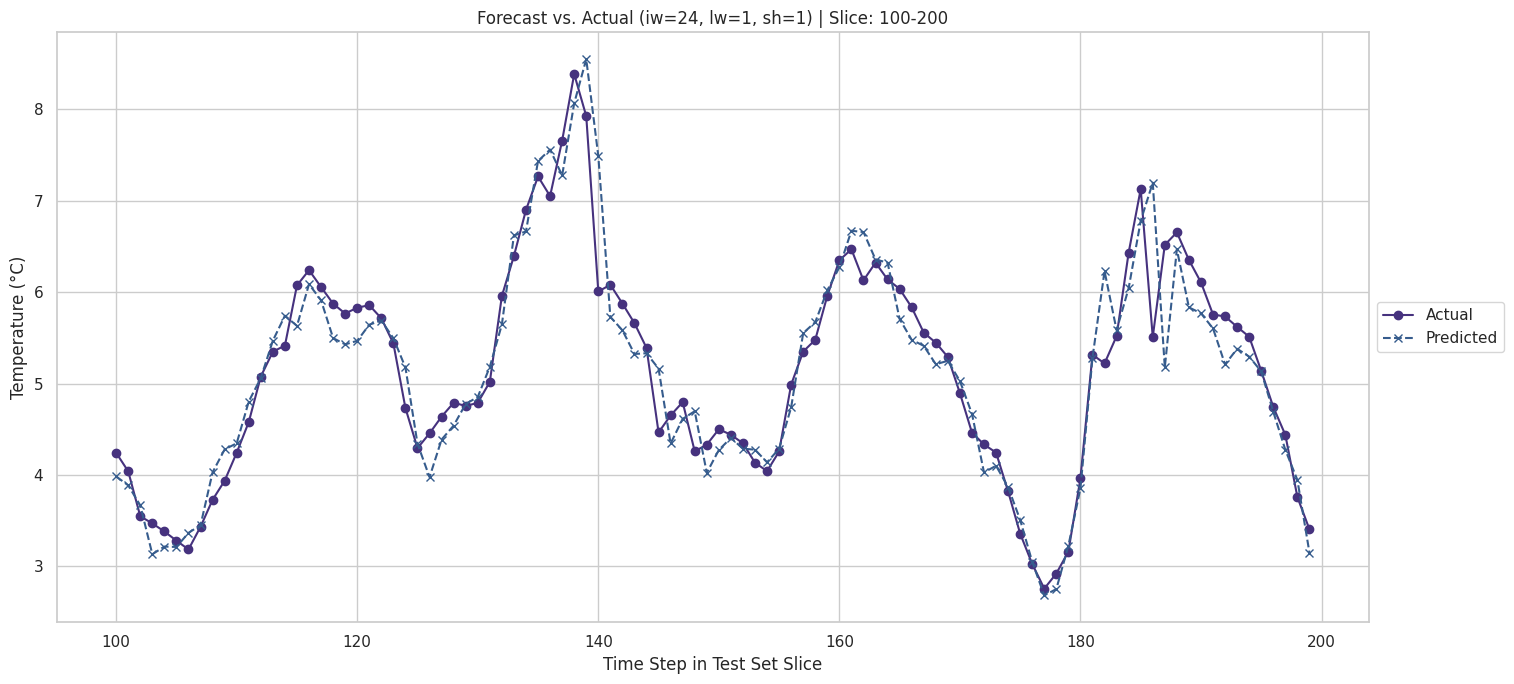

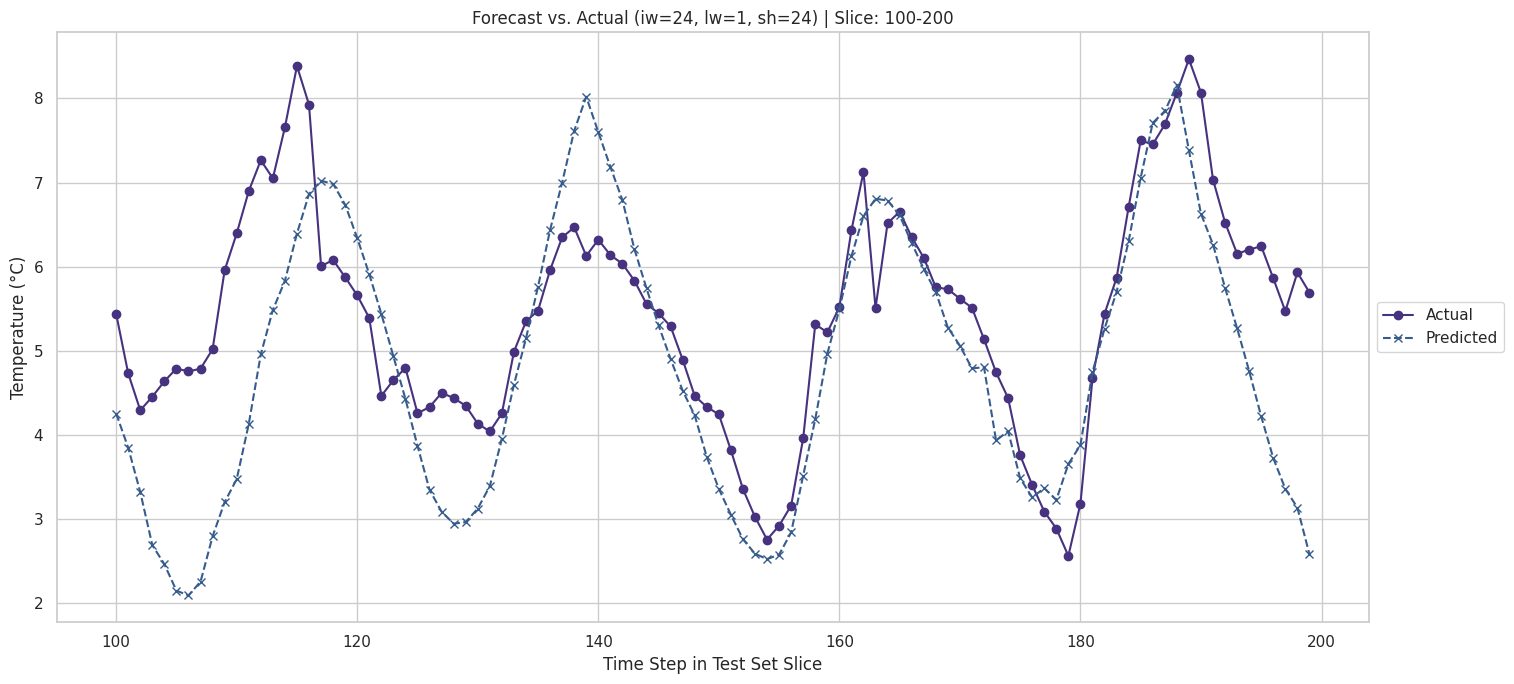

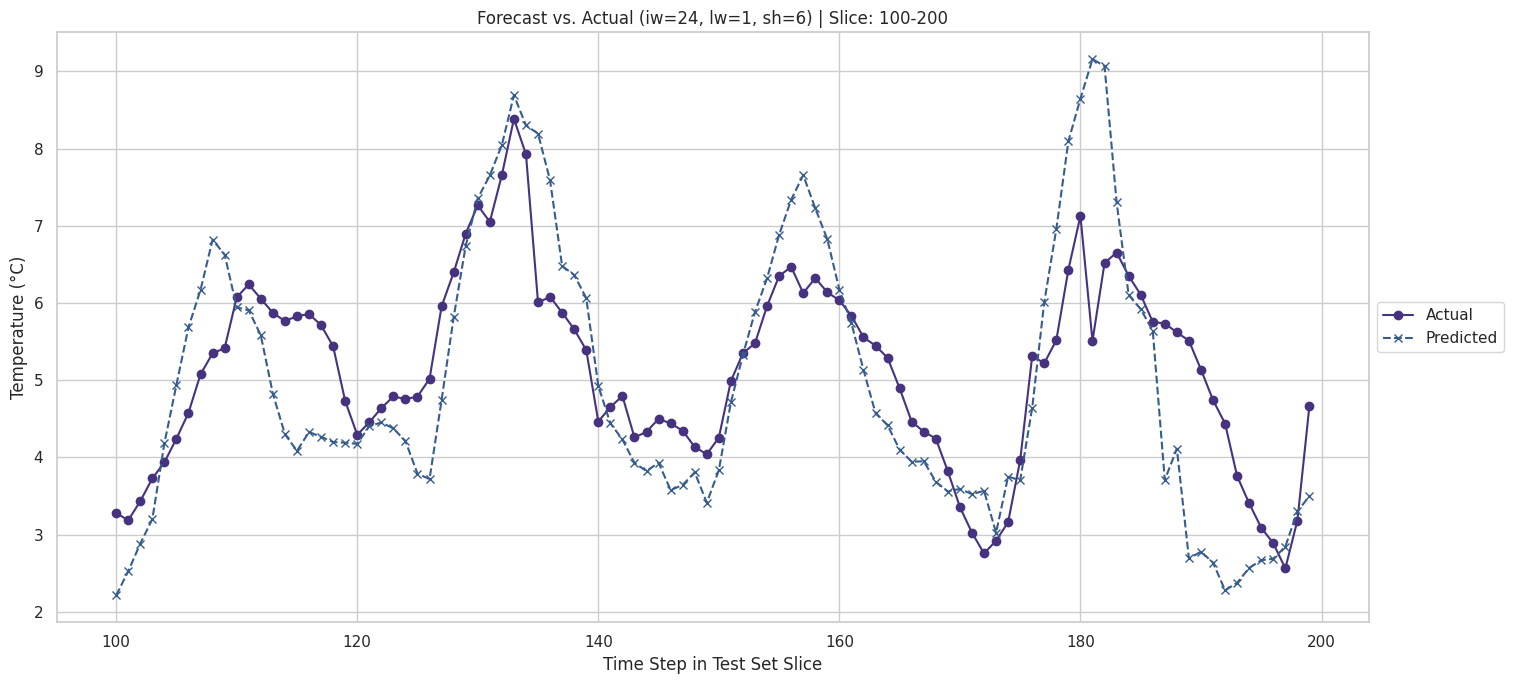

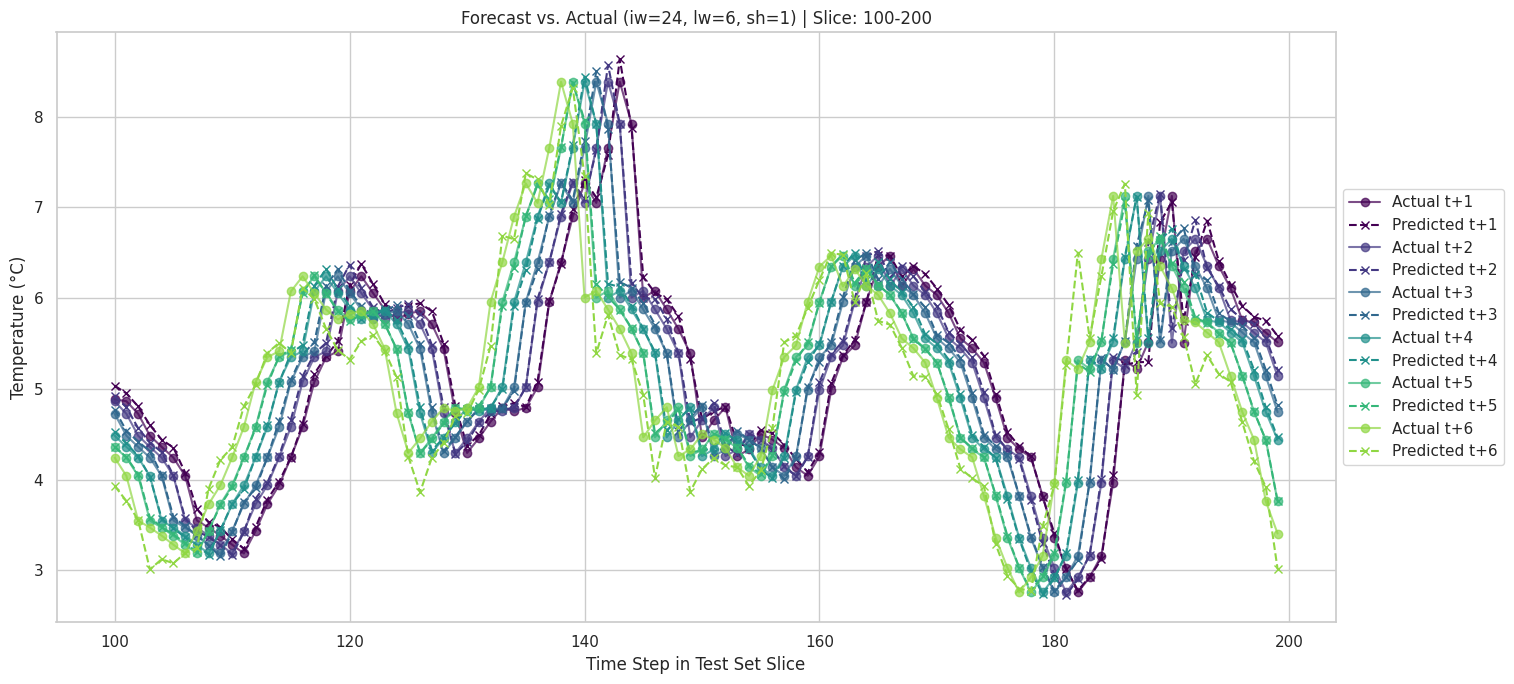

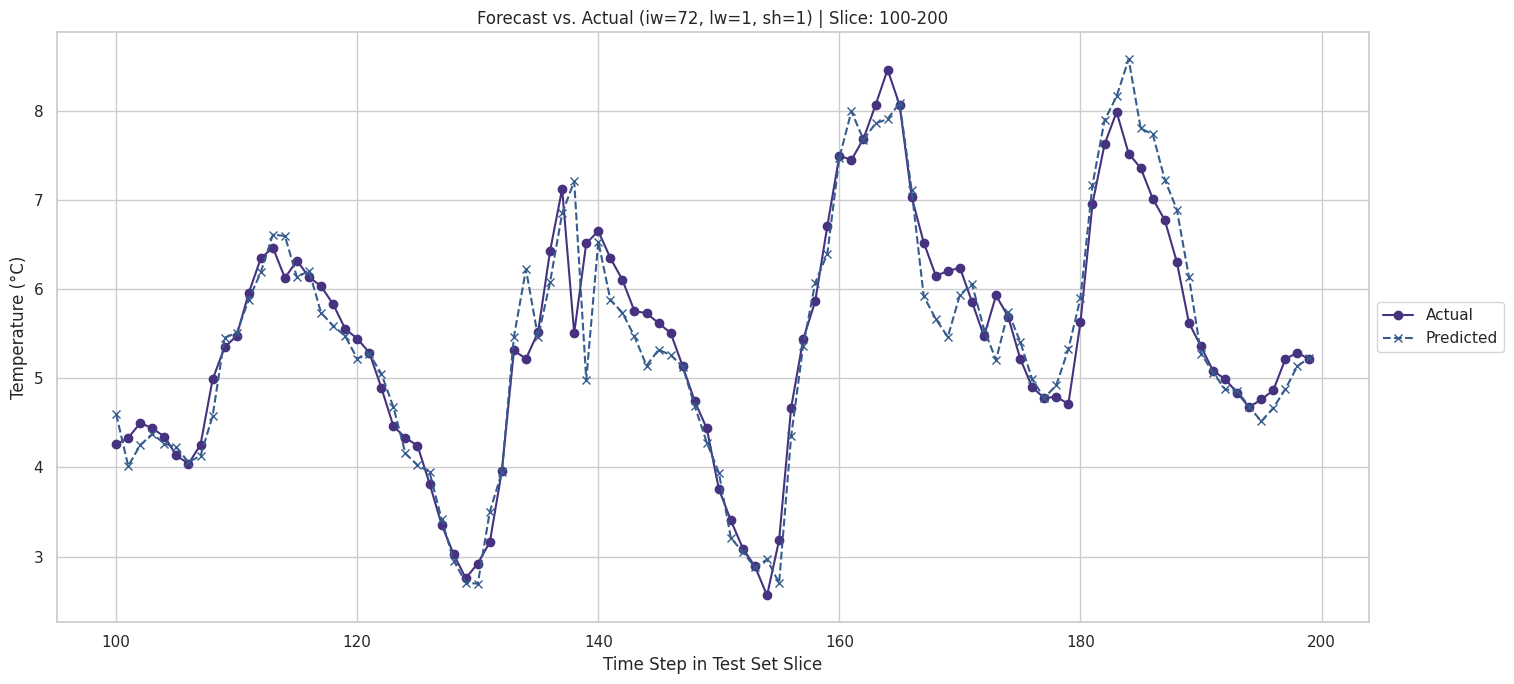

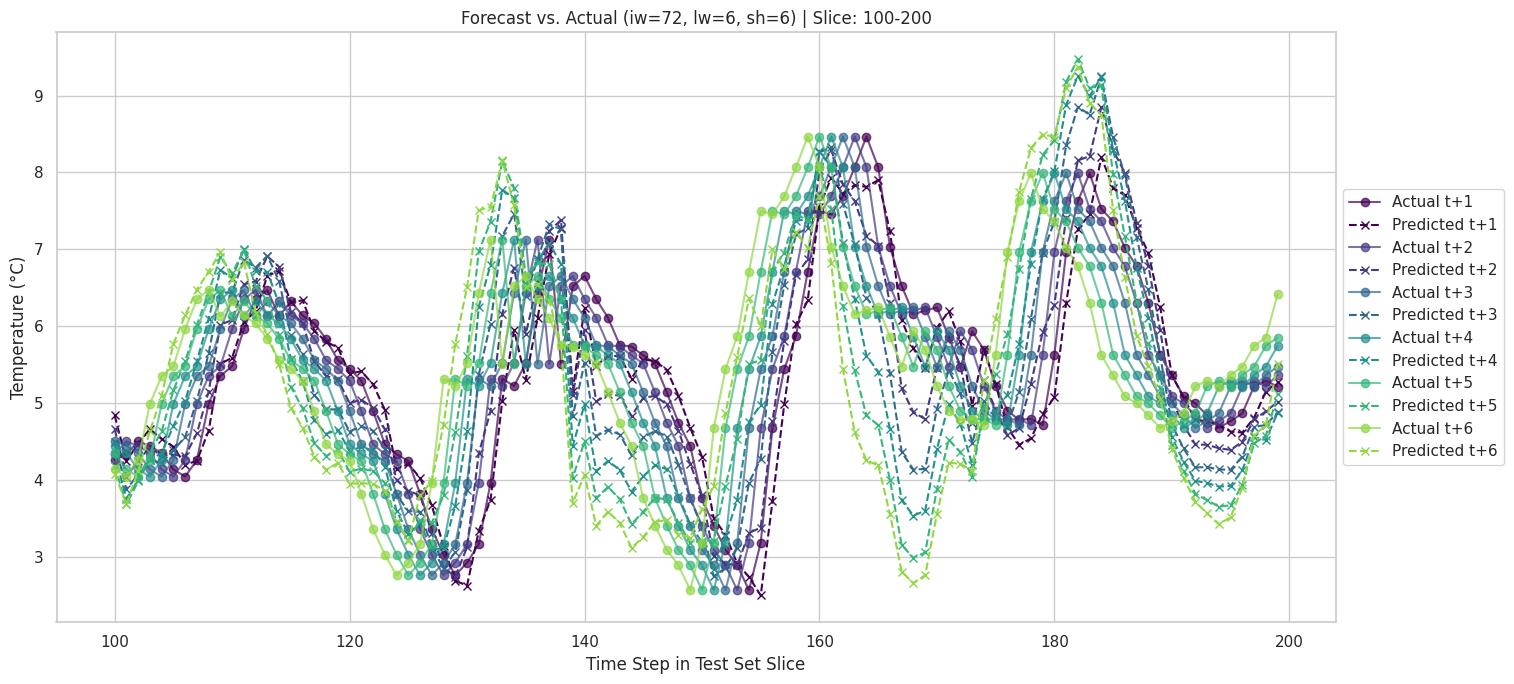

In [4]:
plot_slice = slice(100, 200) # A slice of the test set to keep plots readable

if not result_files:
    print("No results to plot.")
else:
    for file_path in sorted(result_files):
        filename = os.path.basename(file_path)
        match = filename_pattern.match(filename)
        if not match: continue

        # Extract parameters for the title
        input_width, label_width, shift = map(int, match.groups())
        
        # Load data
        df = pd.read_csv(file_path)
        plot_df = df[plot_slice]

        # Start plotting
        plt.figure(figsize=(18, 7))
        
        if label_width == 1:
            # Single-step forecast plot
            plt.plot(plot_df.index, plot_df['actual'], label='Actual', marker='o', linestyle='-', color='C0')
            plt.plot(plot_df.index, plot_df['prediction'], label='Predicted', marker='x', linestyle='--', color='C1')
        else:
            # Multi-step forecast plot
            pred_cols = [f'prediction_t+{i+1}' for i in range(label_width)]
            actual_cols = [f'actual_t+{i+1}' for i in range(label_width)]
            for i in range(label_width):
                color = plt.cm.viridis(i / label_width)
                plt.plot(plot_df.index, plot_df[actual_cols[i]], label=f'Actual t+{i+1}', marker='o', linestyle='-', color=color, alpha=0.7)
                plt.plot(plot_df.index, plot_df[pred_cols[i]], label=f'Predicted t+{i+1}', marker='x', linestyle='--', color=color)

        plt.title(f'Forecast vs. Actual (iw={input_width}, lw={label_width}, sh={shift}) | Slice: {plot_slice.start}-{plot_slice.stop}')
        plt.xlabel('Time Step in Test Set Slice')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
        plt.show()
